In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from pathlib import Path
import datetime as dt

plt.style.use('seaborn')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
# add predicted prices in dataframe format to run through efficient frontier functions
# name dataframe df_closing
csvpath = Path("Resources/forecast_prices.csv")
df_closing = pd.read_csv(csvpath)
df_closing = df_closing.drop(columns=['Unnamed: 0'])
df_closing["Date"] = pd.to_datetime(df_closing["Date"]).dt.date
df_closing = df_closing.set_index("Date")
df_closing

,LQD_close_price,PZA_close_price,USO_close_price,TLT_close_price,QQQ_close_price,VMBS_close_price,VNQ_close_price
Date,,,,,,,
2021-01-13,136.520000,27.090000,35.760000,152.360000,316.000000,54.010000,84.310000
2021-01-14,137.277298,27.027870,35.348991,154.565033,303.799408,54.105686,84.397934
2021-01-15,138.050400,26.947447,35.693897,155.340942,302.885742,54.160480,84.485168
2021-01-16,138.771729,26.877699,35.377987,157.228912,302.805603,54.233402,84.545761
2021-01-17,139.553513,26.820807,35.770760,157.639771,302.869537,54.292553,84.590866
...,...,...,...,...,...,...,...
2021-04-09,187.859833,23.586655,38.171642,178.678375,282.148926,59.169720,89.353844
2021-04-10,187.679001,23.542416,37.488892,178.936768,281.902679,59.225296,89.405312
2021-04-11,187.614365,23.498083,38.227890,179.182495,281.660278,59.280849,89.456543


In [14]:
# rename column headers to sector names
df_closing.columns = ["Corporates","Municipals","Commodities","Treasuries","Equities","MBS", "Realestate"]

In [15]:
# calculate optimal distribution of etf using efficient frontier
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
returns = df_closing.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0
num_assets = len(mean_returns)

In [16]:
# functions to calculate efficient frontier analysis
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((num_assets,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

# find maximum sharpe ratio using scipy.optimize
# there is no "maximize" function so we find the negative sharpe ratio to use with "sco.minimize"
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [17]:
# display function
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    # calculate max sharpe ratio to determine optimal allocation
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df_closing.columns,columns=['Allocation'])
    max_sharpe_allocation.Allocation = [round(i*100,2)for i in max_sharpe_allocation.Allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    # calculate min variance for least volatile portfolio
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df_closing.columns,columns=['Allocation'])
    min_vol_allocation.Allocation = [round(i*100,2)for i in min_vol_allocation.Allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation \n")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("\n")
    #print("Minimum Volatility Portfolio Allocation\n")
    #print("Annualized Return:", round(rp_min,2))
    #print("Annualized Volatility:", round(sdp_min,2))
    #print("\n")
    #print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Optimal Insurance Company Portfolio based on Efficient Frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation 

Annualized Return: 0.23
Annualized Volatility: 0.0


            Corporates  Municipals  Commodities  Treasuries  Equities    MBS  \
Allocation         0.1         0.0         0.02         0.0      1.47  67.34   

            Realestate  
Allocation       31.07  
--------------------------------------------------------------------------------




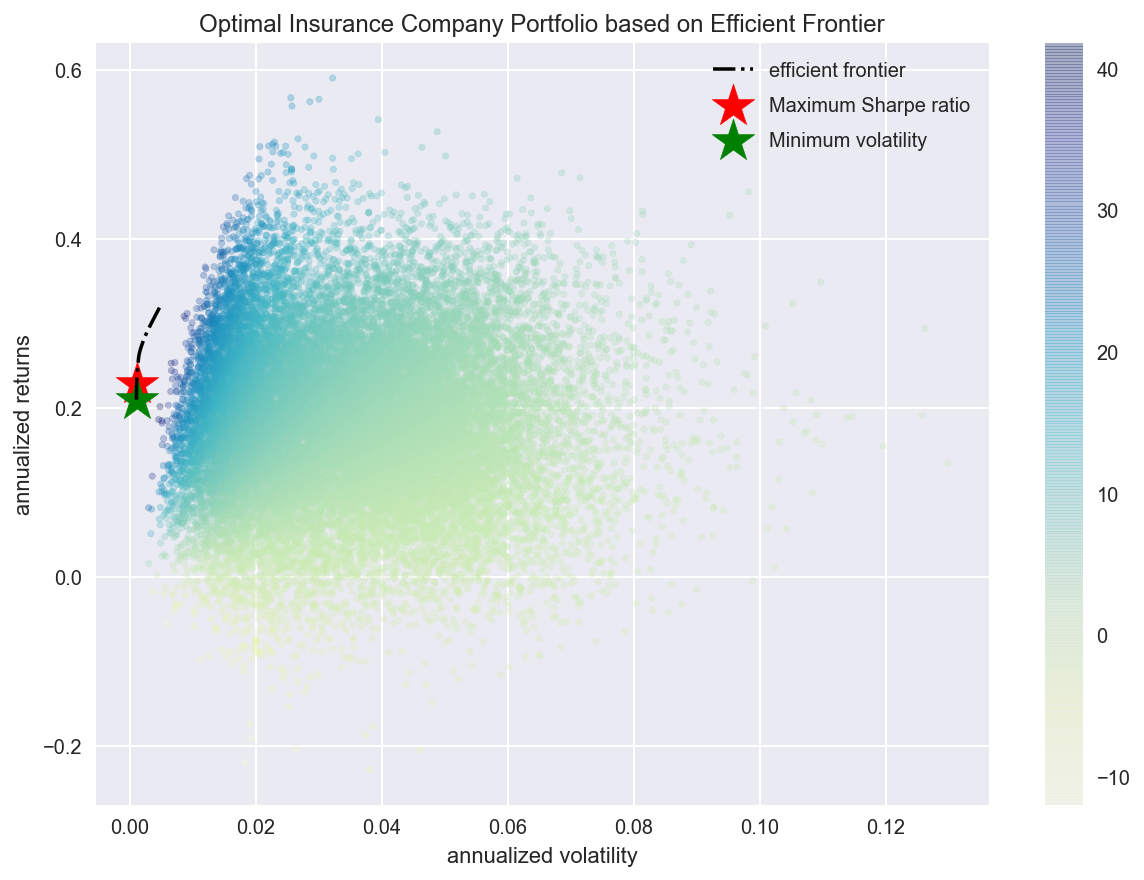

In [18]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)